### 5.2 Grid Search
- 모델 매개변수 튜닝을 통한 일반화 성능 개선 
- 가장 널리 사용되는 방법은 Grid Search (그리드 탐색)

In [1]:
%matplotlib inline
import sys 
sys.path.append('..')
from preamble import *

#### Simple Grid-Search
- SVC 모델에서 가장 중요한 매개변수는 gamma, C
- 그리드 탐색 범위 설정 예
  - gamma: [0.001, 0.01, 0.1, 1, 10, 100]
  - C: [0.001, 0.01, 0.1, 1, 10, 100]
  - 총 6x6=36개의 조합에 대하여 반복적으로 새로운 모델 생성 및 평가
  - 가장 좋은 성능을 보여주는 gamma와 C의 조합을 찾음

In [8]:
# naive grid search implementation
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

iris = load_iris()

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)
print("Size of training set: {}   size of test set: {}".format(X_train.shape[0], X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters, train an SVC
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # evaluate the SVC on the test set
        score = svm.score(X_test, y_test)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

print("Best score: {:.2f}".format(best_score))
print("Best parameters: {}".format(best_parameters))

Size of training set: 112   size of test set: 38
Best score: 0.97
Best parameters: {'C': 100, 'gamma': 0.001}


- 위 0.97의 정확도는 전혀 새로운 데이터에 대한 성능으로 이어지지 않을 수 있다.
- 즉, 위 예제에서 사용한 테스트 데이터는 모델 구성시에 사용을 해버렸기 때문에 이 모델이 얼마나 좋은지 평가하는 데 더 이상 사용할 수 없다.

#### The danger of overfitting the parameters and the validation set
- 검증 데이터 세트 (Valudation Set) 필요
  - 모델 파라미터 튜닝 용도
- 모델을 구성할 때 훈련 데이터 세트와 검증 데이터 세트를 활용

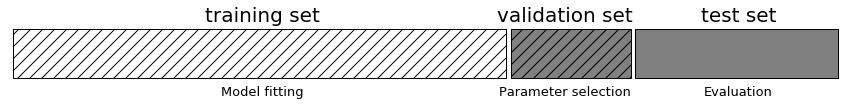

In [9]:
mglearn.plots.plot_threefold_split()

In [10]:
from sklearn.svm import SVC
# split data into train+validation set and test set
X_trainval, X_test, y_trainval, y_test = train_test_split(iris.data, iris.target, random_state=0)

# split train+validation set into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, random_state=1)

print("Size of training set: {}, size of validation set: {},size of test set: {}\n".format(
    X_train.shape[0], 
    X_valid.shape[0], 
    X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters train an SVC
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # evaluate the SVC on the validation set
        score = svm.score(X_valid, y_valid)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

# rebuild a model on the combined training and validation set,
# and evaluate it on the test set
svm = SVC(**best_parameters)

#[NOTE] 훈련 데이터와 검증 데이터를 합쳐서 다시 모델을 구성함
svm.fit(X_trainval, y_trainval)

test_score = svm.score(X_test, y_test)
print("Best score on validation set: {:.2f}".format(best_score))
print("Best parameters: ", best_parameters)
print("Test set score with best parameters: {:.2f}".format(test_score))

Size of training set: 84, size of validation set: 28,size of test set: 38

Best score on validation set: 0.96
Best parameters:  {'C': 10, 'gamma': 0.001}
Test set score with best parameters: 0.92


- 위 예제를 통하여 전혀 새로운 테스트 데이터에 대해 생성한 모델은 92%의 정확도로 분류한다고 볼 수 있음

#### Grid-search with cross-validation
- 그리드 탐색에서도 교차 검증 필요
  - 위 두 예제에서 최고의 성능을 보여주는 파라미터가 변경된 점을 주의

In [12]:
from sklearn.model_selection import cross_val_score

# reference: manual_grid_search_cv
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters,
        # train an SVC
        svm = SVC(gamma=gamma, C=C)
        # perform cross-validation
        scores = cross_val_score(svm, X_trainval, y_trainval, cv=5)
        # compute mean cross-validation accuracy
        score = np.mean(scores)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
# rebuild a model on the combined training and validation set
svm = SVC(**best_parameters)

#[NOTE] 훈련 데이터와 검증 데이터를 합쳐서 다시 모델을 구성함
svm.fit(X_trainval, y_trainval)

test_score = svm.score(X_test, y_test)
print("Best score on validation set: {:.2f}".format(best_score))
print("Best parameters: ", best_parameters)
print("Test set score with best parameters: {:.2f}".format(test_score))

Best score on validation set: 0.97
Best parameters:  {'C': 100, 'gamma': 0.01}
Test set score with best parameters: 0.97


- 위 예에서는 반복적인 모델 생성 작업이 36 * 5 = 180번 이루어짐
  - 즉, 시간이 많이 소요됨에 주의

/Users/jslee/Anaconda3/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/jslee/Anaconda3/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/jslee/Anaconda3/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Us

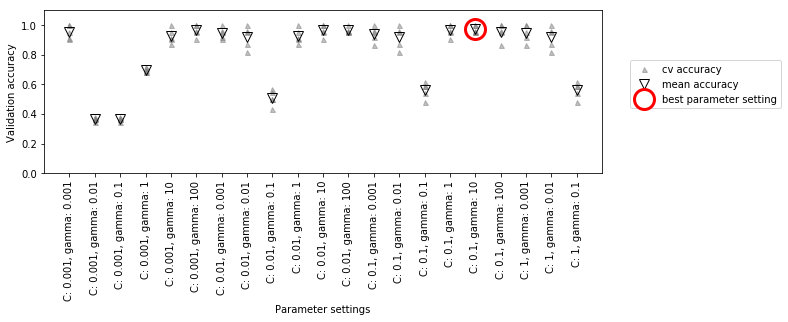

In [13]:
mglearn.plots.plot_cross_val_selection()

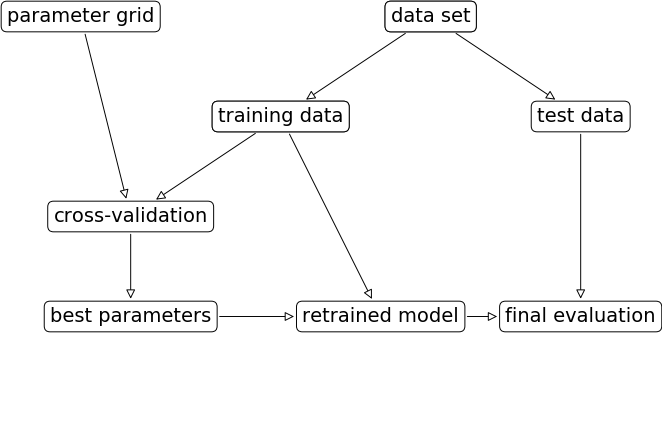

In [14]:
mglearn.plots.plot_grid_search_overview()

- model_selection.GridSearchCV
  - 교차 검증을 사용하는 그리드 탐색을 통한 모델 구성
  - 분류에는 StratifiedKFold 사용함
  - 회귀에는 KFold 사용함
- 다른 estimator (or 모델)를 사용하여 만들어지는 estimator를 메타 추정기(meta-estimator)라고 함.
  - GridSearchCV는 가장 널리 사용되는 메타 추정기
  - scikit-learn에서는 MetaEstimatorMixin 클래스를 상속한 모델을 메타 추정기라고 부름
  - 메타 추정기 예
    - GridSearchCV
    - RandomForest
    - GradientBoosting
    - RFE
    - ...

- 우선 모델에 들어갈 각 매개변수 값을 사전(Dict)타입으로 구성
  - 문자열 매개변수 이름을 모델(예:SVC)에 설정된 매개변수와 동일하게 맞춤 

In [15]:
param_grid = {    'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
print("Parameter grid:\n{}".format(param_grid))

Parameter grid:
{'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}


- GridSearchCV 생성
  - fold의 개수는 cv=5와 같이 설정

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
grid_search = GridSearchCV(SVC(), param_grid, cv=5, return_train_score=True)

- 훈련 데이터와 테스트 데이터 분리